# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. 

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [184]:
!pip install sqlalchemy 

In [185]:
!pip install psycopg2-binary 

In [ ]:
import pandas as pd

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [ ]:
load_dotenv()

In [ ]:
db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [ ]:
connection_string = (
    f"postgresql+psycopg2://{db_config['user']}:{db_config['pwd']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['db']}"
)

In [189]:
engine = create_engine(connection_string) 

In [190]:
query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

-- запрос
SELECT
    p.user_id
  , p.device_type_canonical
  , p.order_id
  , p.created_dt_msk AS order_dt
  , p.created_ts_msk AS order_ts
  , p.currency_code
  , p.revenue
  , p.tickets_count
  , p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER (
          PARTITION BY p.user_id
          ORDER BY p.created_dt_msk
        ) AS days_since_prev
  , e.event_id
  , e.event_name_code AS event_name
  , e.event_type_main
  , p.service_name
  , r.region_name
  , c.city_name

FROM afisha.purchases AS p
JOIN afisha.events    AS e ON e.event_id = p.event_id
JOIN afisha.city      AS c ON c.city_id  = e.city_id
JOIN afisha.regions   AS r ON r.region_id = c.region_id

WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'

ORDER BY p.user_id;
'''

In [191]:
# Результат выдачи SQL-запроса в датафрейм
df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [192]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [193]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


Информация о датафрейме:

- 290611 строк
- 15 столбцов
- Объём 33.3+ МБ

Пропуски содержатся только в 'days_since_prev', что логично, так как для пользователей с одной покупкой — значение пропущено

Cтолбец 'revenue'
- присутствуют отрицательные значения

Формат значений в данных корректен: даты и временные метки представлены в формате datetime, числовые и категориальные признаки соответствуют своему смыслу. Пропуски в поле 'days_since_prev' являются ожидаемыми и связаны с первой покупкой пользователя. Существенных ошибок формата не выявлено.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [194]:
tenge_rate_df = pd.read_csv(
    'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
)
tenge_rate_df

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [195]:
df.loc[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка


In [196]:
tenge_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [197]:
# приведение дат
tenge_rate_df['data'] = pd.to_datetime(tenge_rate_df['data'])
df['order_dt'] = pd.to_datetime(df['order_dt'])

rate_by_date = tenge_rate_df.set_index('data')['curs']
# преобразование валют
def convert(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    return row['revenue'] * rate_by_date[row['order_dt']] / 100

df['revenue_rub'] = df.apply(convert, axis=1)

In [198]:
df.loc[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [199]:
# Проверка на пропуски
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Как уже отмечалось пропуски в поле 'days_since_prev' являются ожидаемыми и связаны с первой покупкой пользователя.

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [201]:
# Преобразование типов данных
df['revenue_rub'] = df['revenue_rub'].astype('float32')
df['tickets_count'] = df['tickets_count'].astype('int16')
df['event_id'] = df['event_id'].astype('int32')
df['days_since_prev'] = df['days_since_prev'].astype('float32')

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int16         
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [203]:
#Рассмотрим строки с отрицательными суммами в заказах
neg_revenue = df[df['revenue_rub'] < 0]

neg_revenue.head(5)


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
252,00eb3dc9baa1543,mobile,1594653,2024-06-29,2024-06-29 15:01:43,rub,-2.37,3,NaN,538650,ffe03bc6-0e0c-480d-b037-6a4b55540ab5,другое,Билеты без проблем,Берёзовская область,Златопольск,-2.37
4522,02ea4583333f064,mobile,2360920,2024-09-03,2024-09-03 18:12:58,rub,-0.23,3,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,Билеты без проблем,Широковская область,Лесореченск,-0.23
4549,02ea4583333f064,mobile,2361094,2024-09-04,2024-09-04 09:34:53,rub,-0.15,2,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,Билеты без проблем,Широковская область,Лесореченск,-0.15
8133,043f669c9f734b1,mobile,166809,2024-09-27,2024-09-27 10:56:35,rub,-0.62,1,1.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,Лучшие билеты,Золотоключевской край,Луговинец,-0.62
8134,043f669c9f734b1,mobile,166780,2024-09-27,2024-09-27 10:00:09,rub,-1.86,3,0.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,Лучшие билеты,Золотоключевской край,Луговинец,-1.86


In [204]:
neg_cnt = (df['revenue_rub'] < 0).sum()
total_cnt = len(df)

neg_share = neg_cnt / total_cnt

print(f"Заказы с отрицательной выручкой: {neg_cnt}")
print(f"Доля от общего числа заказов: {neg_share:.3}")

Заказы с отрицательной выручкой: 381
Доля от общего числа заказов: 0.00131


In [205]:
# Сохранение информации о датафрейме до фильтрации
rows_before = df.shape[0]

In [206]:
#Уберем значения с отрицательной выручкой
df = df[df['revenue_rub'] >= 0].copy()

In [207]:
# Сохранение информации о датафрейме после фильтрации строк с отрицательной выручкой
rows_after = df.shape[0]

In [208]:
rows_removed = rows_before - rows_after
rows_removed_share = rows_removed / rows_before

print(f'Удалено строк: {rows_removed}')
print(f'Доля удалённых строк: {rows_removed_share:.3f}')

Удалено строк: 381
Доля удалённых строк: 0.001


In [209]:
# Нормализация данных в категориальных столбцах
cat_cols = [
    'device_type_canonical'
  , 'currency_code'
  , 'event_type_main'
  , 'service_name'
  , 'region_name'
  , 'city_name'
]

for col in cat_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
    )
for col in cat_cols:
    print(f'\nСтолбец: {col}')
    print(
        df[col]
        .value_counts()
        .tail(20)
    )


Столбец: device_type_canonical
mobile     232132
desktop     58098
Name: device_type_canonical, dtype: int64

Столбец: currency_code
rub    285161
kzt      5069
Name: currency_code, dtype: int64

Столбец: event_type_main
концерты    115275
театр        67321
другое       65552
спорт        21889
стендап      13393
выставки      4811
ёлки          1989
Name: event_type_main, dtype: int64

Столбец: service_name
быстробилет           2003
выступления.ру        1616
восьмёрка             1118
crazy ticket!          790
росбилет               539
шоу начинается!        499
быстрый кассир         381
радио ticket           376
телебилет              321
карандашру             133
реестр                 125
билет по телефону       85
вперёд!                 80
дырокол                 74
кино билет              67
цвет и билет            61
тех билет               22
лимоны                   8
зе бест!                 5
билеты в интернете       4
Name: service_name, dtype: int64

Столбец: reg

In [210]:
print(df['city_name'].nunique())
print(df['region_name'].nunique())

352
81


In [211]:
#Проверка категориальных признаков на наличие псевдопропусков
pseudo_missing = {'нет', 'не указано', 'unknown', 'none', '-', '', 'null', 'nan'}

(df['city_name']
 .astype(str)
 .str.strip()
 .str.lower()
 .isin(pseudo_missing)
 .sum()
)

0

In [212]:
#Проверка категориальных признаков на наличие псевдопропусков
pseudo_missing = {'нет', 'не указано', 'unknown', 'none', '-', '', 'null', 'nan'}

(df['region_name']
 .astype(str)
 .str.strip()
 .str.lower()
 .isin(pseudo_missing)
 .sum()
)

0

В данных представлено 352 уникальных города и 81 уникальный регион.

Проверка категориальных признаков на наличие псевдопропусков (в том числе редких значений) не выявила значений, обозначающих отсутствие информации.

In [213]:
df.duplicated().sum()

0

In [214]:
df.duplicated(subset='order_id').sum()

0

Полные дубликаты строк и дубликаты заказов по 'order_id' отсутствуют

In [215]:
#Проверяет неявные дубликаты по заданному набору ключевых колонок

def check_implicit_duplicates(df, key_cols):
    dup_rows_cnt = df.duplicated(subset=key_cols, keep=False).sum()
    dup_rows_share = dup_rows_cnt / len(df)
    
    return {
        'Ключ': key_cols,
        'Количество неявных дубликатов по ключу': dup_rows_cnt,
        'Доля неявных дубликатов по ключу': round(dup_rows_share, 5)
    }



In [216]:
key = [col for col in df.columns if col != 'order_id']

check_implicit_duplicates(
    df,
    key
)

{'Ключ': ['user_id',
  'device_type_canonical',
  'order_dt',
  'order_ts',
  'currency_code',
  'revenue',
  'tickets_count',
  'days_since_prev',
  'event_id',
  'event_name',
  'event_type_main',
  'service_name',
  'region_name',
  'city_name',
  'revenue_rub'],
 'Количество неявных дубликатов по ключу': 59,
 'Доля неявных дубликатов по ключу': 0.0002}

- Проверка на строки которые полностью совпадают по содержанию заказа, мероприятия, пользователя и выручки,
но имеют разный 'order_id' показала наличие 59 неявных дубликатов. Это похоже на технический сбой поэтому удалим эти значения.

In [217]:
key_cols = [col for col in df.columns if col != 'order_id']

df = df.drop_duplicates(subset=key_cols, keep='first').copy()

In [218]:
df[['revenue_rub', 'tickets_count']].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99]
)

,revenue_rub,tickets_count
count,290199.000000,290199.000000
mean,556.313904,2.755161
std,875.861511,1.170618
min,0.000000,1.000000
50%,352.079987,3.000000
90%,1294.849976,4.000000
95%,1630.650024,5.000000
99%,2628.421631,6.000000
max,81174.539062,57.000000


In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

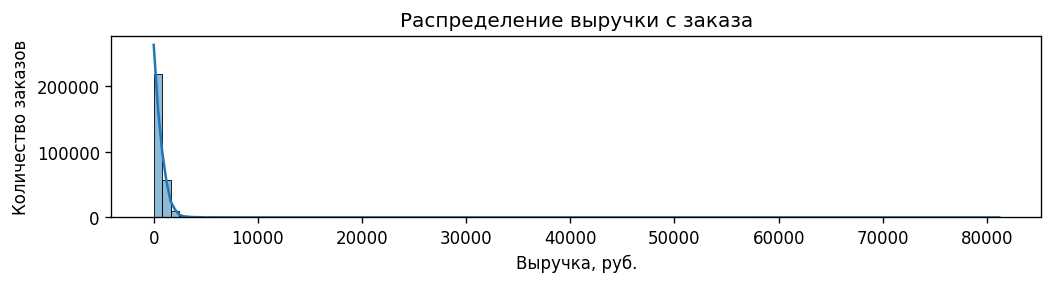

In [220]:
plt.figure(figsize=(10, 2), dpi=120)
sns.histplot(df['revenue_rub'], bins=100, kde=True)
plt.title('Распределение выручки с заказа')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.show()

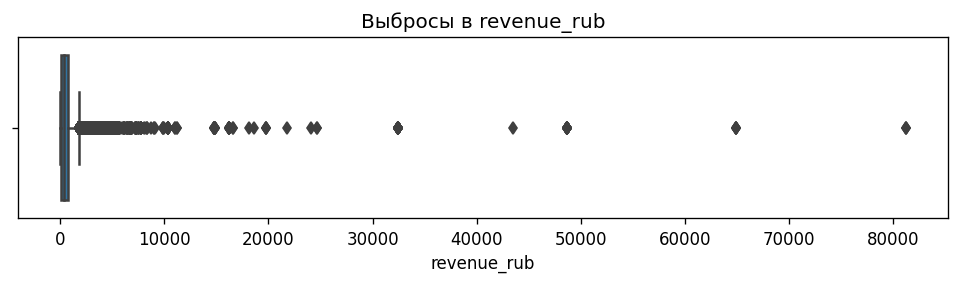

In [221]:
plt.figure(figsize=(10, 2), dpi=120)
sns.boxplot(x=df['revenue_rub'])
plt.title('Выбросы в revenue_rub')
plt.show()

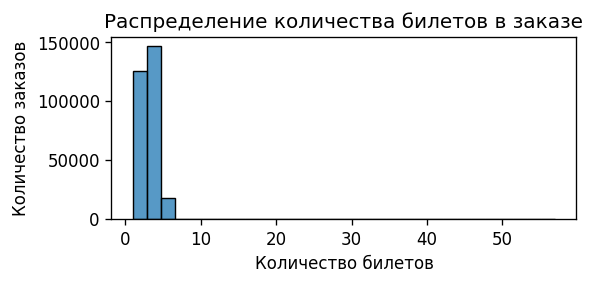

In [222]:
plt.figure(figsize=(5, 2), dpi=120)
sns.histplot(df['tickets_count'], bins=30)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Количество заказов')
plt.show()

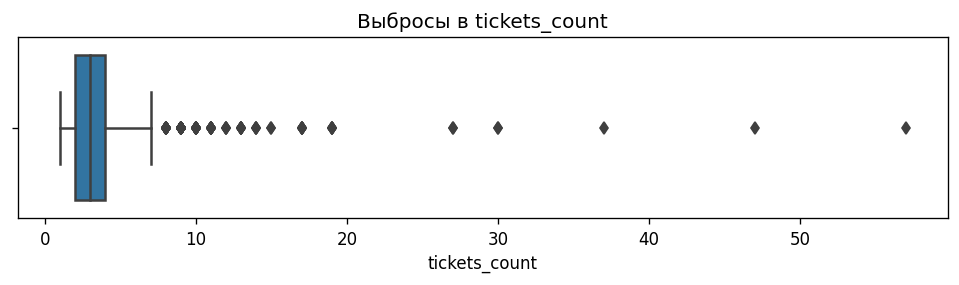

In [223]:
plt.figure(figsize=(10, 2), dpi=120)
sns.boxplot(x=df['tickets_count'])
plt.title('Выбросы в tickets_count')
plt.show()

In [224]:
df_before_p99 = df.copy()

In [225]:
p99 = df['revenue_rub'].quantile(0.99)
p99

2628.421630859375

In [226]:
rows_before_p99 = df_before_p99.shape[0]

df = df_before_p99[df_before_p99['revenue_rub'] <= p99].copy()

rows_after_p99 = df.shape[0]

filtered_rows_p99 = rows_before_p99 - rows_after_p99
filtered_share_p99 = filtered_rows_p99 / rows_before_p99

print(f'Строк было: {rows_before_p99}')
print(f'Удалено при фильтрации по p99: {filtered_rows_p99}')
print(f'Доля удалённых строк: {filtered_share_p99:.2f}')
print(f'Порог p99: {p99:.2f} руб.')

Строк было: 290199
Удалено при фильтрации по p99: 2825
Доля удалённых строк: 0.01
Порог p99: 2628.42 руб.


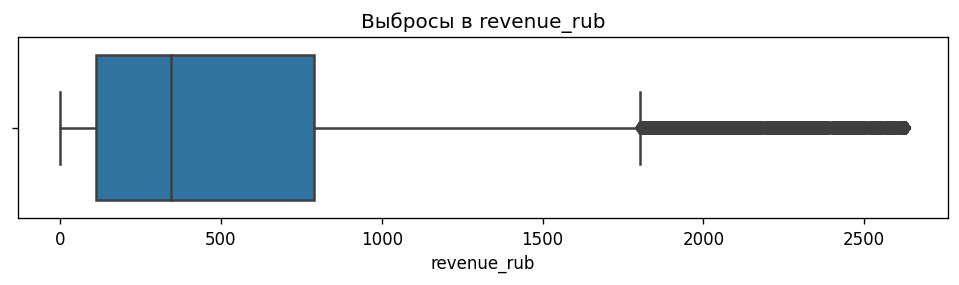

In [227]:
plt.figure(figsize=(10, 2), dpi=120)
sns.boxplot(x=df['revenue_rub'])
plt.title('Выбросы в revenue_rub')
plt.show()

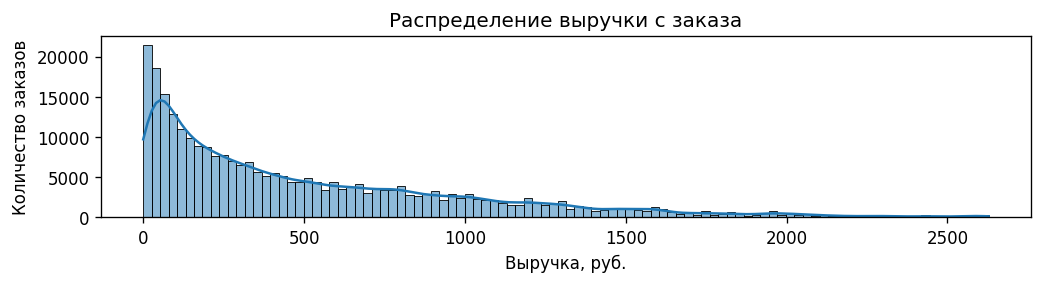

In [228]:
plt.figure(figsize=(10, 2), dpi=120)
sns.histplot(df['revenue_rub'], bins=100, kde=True)
plt.title('Распределение выручки с заказа')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.show()

In [229]:
df[['revenue_rub']].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99]
)

,revenue_rub
count,287374.000000
mean,518.724609
std,511.938232
min,0.000000
50%,344.834991
90%,1258.569946
95%,1572.760010
99%,2156.080078
max,2628.421631


In [230]:
rows_after = df.shape[0]

removed_rows = rows_before - rows_after
removed_share = removed_rows / rows_before

print(f'Строк до предобработки: {rows_before}')
print(f'Строк после предобработки: {rows_after}')
print(f'Удалено строк: {removed_rows}')
print(f'Доля удалённых строк: {removed_share:.3f}')

Строк до предобработки: 290611
Строк после предобработки: 287374
Удалено строк: 3237
Доля удалённых строк: 0.011


В распределении выручки с заказа были обнаружены экстремальные значения. В соответствии с условиями задания выбросы в поле 'revenue_rub' были отфильтрованы по 99-му перцентилю (порог 2628.42 руб.). Также были удалены строки с отрицательными значениями выручки
В результате фильтрации было удалено 3237 строк, что составляет около 0.011 от общего объёма данных.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [231]:
# Сортировка данных по времени совершения заказа
df = df.sort_values(['user_id', 'order_ts'])

In [232]:
df[['user_id', 'order_dt', 'order_ts']].head()

,user_id,order_dt,order_ts
0,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03
1,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24
2,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02
3,000898990054619,2024-07-13,2024-07-13 19:40:48
4,000898990054619,2024-10-04,2024-10-04 22:33:15


In [233]:
# Построение профиля пользователя
user_profile = (
    df
    .groupby('user_id')
    .agg(
        first_order_dt=('order_dt', 'first'),
        last_order_dt=('order_dt', 'last'),
        first_device=('device_type_canonical', 'first'),
        first_region=('region_name', 'first'),
        first_service=('service_name', 'first'),
        first_event_type=('event_type_main', 'first'),
        orders_count=('order_id', 'nunique'),
        avg_revenue_rub=('revenue_rub', 'mean'),
        avg_tickets_count=('tickets_count', 'mean'),
        avg_days_between_orders=('days_since_prev', 'mean')
    )
    .reset_index()
)
display(user_profile.head())

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,orders_count,avg_revenue_rub,avg_tickets_count,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0


In [234]:
# Добавление бинарных признаков
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int)

In [235]:
user_profile[['orders_count', 'is_two', 'is_five']].head(6)

,orders_count,is_two,is_five
0,1,0,0
1,2,1,0
2,3,1,0
3,1,0,0
4,2,1,0
5,13,1,1


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [236]:
#Общее число пользователей в выборке
total_users = user_profile['user_id'].nunique()

#Cреднюю выручку с одного заказа
mean_revenue_per_order = user_profile['avg_revenue_rub'].mean()

#Доля пользователей, совершивших 2 и более заказа
share_two_plus = user_profile['is_two'].mean()

#Доля пользователей, совершивших 5 и более заказов
share_five_plus = user_profile['is_five'].mean()

print(f'Общее число пользователей: {total_users}')
print(f'Средняя выручка с одного заказа: {mean_revenue_per_order:.2f} руб.')
print(f'Доля пользователей, совершивших 2 и более заказа: {share_two_plus:.2f}')
print(f'Доля пользователей, совершивших 5 и более заказов: {share_five_plus:.2f}')

Общее число пользователей: 21838
Средняя выручка с одного заказа: 545.03 руб.
Доля пользователей, совершивших 2 и более заказа: 0.62
Доля пользователей, совершивших 5 и более заказов: 0.29


In [237]:
user_profile[[
    'orders_count',
    'avg_tickets_count',
    'avg_days_between_orders'
]].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

,orders_count,avg_tickets_count,avg_days_between_orders
count,21838.000000,21838.000000,13504.000000
mean,13.159355,2.744059,15.864843
std,121.565063,0.913072,22.330212
min,1.000000,1.000000,0.000000
50%,2.000000,2.750000,8.000000
90%,15.000000,4.000000,41.500000
95%,31.000000,4.000000,61.500000
99%,152.000000,5.000000,112.000000
max,10168.000000,11.000000,148.000000


In [238]:
p99_orders = user_profile['orders_count'].quantile(0.99)
p99_orders

152.0

In [239]:
rows_before = user_profile.shape[0]

user_profile_clean = (
    user_profile[user_profile['orders_count'] <= p99_orders]
    .copy()
)

rows_after = len(user_profile_clean)
removed = rows_before - rows_after
share_removed = removed / rows_before

In [240]:
print(f'Пользователей было: {rows_before}')
print(f'Стало: {rows_after}')
print(f'Удалено: {removed} ({share_removed:.3f})')
print(f'Порог p99: {p99_orders}')

Пользователей было: 21838
Стало: 21622
Удалено: 216 (0.010)
Порог p99: 152.0


In [241]:
user_profile_clean[[
    'orders_count',
    'avg_tickets_count',
    'avg_days_between_orders'
]].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

,orders_count,avg_tickets_count,avg_days_between_orders
count,21622.000000,21622.000000,13288.000000
mean,6.496023,2.744253,16.115269
std,14.309326,0.917481,22.423697
min,1.000000,1.000000,0.000000
50%,2.000000,2.750000,8.375000
90%,14.000000,4.000000,42.000000
95%,26.000000,4.000000,62.000000
99%,79.790000,5.000000,113.000000
max,152.000000,11.000000,148.000000


В распределении общего числа заказов на пользователя были выявлены экстремальные значения: при медиане 2 заказа максимальное значение превышало 10 000. Для снижения влияния таких наблюдений профили пользователей были отфильтрованы по 99-му перцентилю показателя 'orders_count' (порог 152). В результате было удалено 216 пользователей, что составляет 0.01 от выборки.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [242]:
event_type_dist = (
    user_profile_clean
    .groupby('first_event_type')
    .agg(users_cnt=('user_id', 'count'))
    .reset_index()
)

event_type_dist['share'] = (
    event_type_dist['users_cnt'] / event_type_dist['users_cnt'].sum()
)

event_type_dist = (
    event_type_dist
    .sort_values('users_cnt', ascending=False)
    .reset_index(drop=True)
)
event_type_dist

,first_event_type,users_cnt,share
0,концерты,9564,0.442327
1,другое,5401,0.249792
2,театр,4245,0.196328
3,стендап,1110,0.051337
4,спорт,794,0.036722
5,выставки,413,0.019101
6,ёлки,95,0.004394


Распределение пользователей по типу первого мероприятия является неравномерным. Наибольшее количество пользователей сервиса берут билеты на "концерты" - около 0.44 пользователей. Также популярными категориями являются "другое" и "театр". Остальные типы мероприятий представлены существенно меньшими долями и носят нишевой характер.

In [243]:
device_type_dist = (
    user_profile_clean
    .groupby('first_device')
    .agg(users_cnt=('user_id', 'count'))
    .reset_index()
)

device_type_dist['share'] = (
    device_type_dist['users_cnt'] / device_type_dist['users_cnt'].sum()
)

device_type_dist = (
    device_type_dist
    .sort_values('users_cnt', ascending=False)
    .reset_index(drop=True)
)
device_type_dist

,first_device,users_cnt,share
0,mobile,17906,0.828138
1,desktop,3716,0.171862


Распределение пользователей по типу устройства первого заказа также является неравномерным. В основном пользователи начинают взаимодействие с сервисом с мобильных устройств - 0.83 пользователей. Десктоп для первого заказа значительно менее популярен 0.17

In [244]:
region_dist = (
    user_profile_clean
    .groupby('first_region')
    .agg(users_cnt=('user_id', 'count'))
    .reset_index()
)

region_dist['share'] = (
    region_dist['users_cnt'] / region_dist['users_cnt'].sum()
)

region_dist = (
    region_dist
    .sort_values('users_cnt', ascending=False)
    .reset_index(drop=True)
)
region_dist

,first_region,users_cnt,share
0,каменевский регион,7086,0.327722
1,североярская область,3768,0.174267
2,широковская область,1223,0.056563
3,озернинский край,675,0.031218
4,малиновоярский округ,526,0.024327
...,...,...,...
76,залесский край,2,0.000092
77,тихогорская область,2,0.000092
78,верхозёрский край,1,0.000046
79,сосноводолинская область,1,0.000046


Распределение пользователей по региону первого заказа является неравномерным - 0.33 пользователей совершают первый заказ в каменевском регионе, 0.17 - в североярской области. Два региона формируют почти половину пользовательской базы.

In [245]:
service_dist = (
    user_profile_clean
    .groupby('first_service')
    .agg(users_cnt=('user_id', 'count'))
    .reset_index()
)

service_dist['share'] = (
    service_dist['users_cnt'] / service_dist['users_cnt'].sum()
)

service_dist = (
    service_dist
    .sort_values('users_cnt', ascending=False)
    .reset_index(drop=True)
)
service_dist

,first_service,users_cnt,share
0,билеты без проблем,5167,0.238970
1,мой билет,2970,0.137360
2,лови билет!,2812,0.130053
3,билеты в руки,2557,0.118259
4,облачко,2177,0.100684
5,весь в билетах,1286,0.059476
6,лучшие билеты,1182,0.054667
7,прачечная,583,0.026963
8,край билетов,454,0.020997
9,дом культуры,356,0.016465


Распределение по операторам продавшим пользователю первый заказ неоднородное. Топ-5 билетных операторов формируют более 0.7 пользовательской базы.

Наиболее значимыми точками входа являются концерты как тип первого мероприятия, мобильные устройства как основной канал первого заказа, а также ограниченное число регионов и билетных операторов. В частности, около 0.44 пользователей начинают с концертов, 0.33 пользователей совершают первый заказ в каменевском регионе, 0.83 - с мобильных устройств, топ-5 билетных операторов формируют более 0.7 пользовательской базы.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [246]:
def segment_return(df, segment_col):
    return (
        df
        .groupby(segment_col, dropna=False)
        .agg(
            users_cnt=('user_id', 'count'),
            share_two=('is_two', 'mean')
        )
        .reset_index()
    )


# 2) Отбор: топ-N по числу пользователей
def top_by_users(seg_df, top_n=10):
    return (
        seg_df
        .sort_values('users_cnt', ascending=False)  
        .head(top_n)
        .reset_index(drop=True)
    )


# 3) График: рисуем топ-N по users_cnt
def plot_top_segments(
    df,
    segment_col,
    top_n=10,
    figsize=(7, 4),
    dpi=120
):
    seg_df = segment_return(df, segment_col)


    top_df = (
        seg_df
        .sort_values('users_cnt', ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    plt.figure(figsize=figsize, dpi=dpi)
    sns.barplot(
        data=top_df,
        x='share_two',
        y=segment_col,
        orient='h'
    )

    plt.xlabel('Доля пользователей с 2 и более заказами')
    plt.ylabel('Сегмент')
    plt.title(f'Возврат пользователей по {segment_col} (топ-{top_n} по числу пользователей)')
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.25)
    plt.show()
#возвращаем таблицу
    return top_df

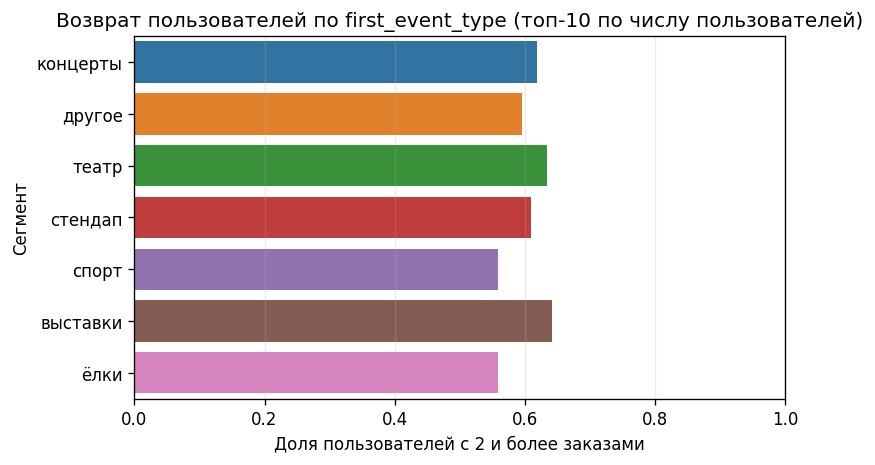

,first_event_type,users_cnt,share_two
0,концерты,9564,0.618151
1,другое,5401,0.595630
2,театр,4245,0.634393
3,стендап,1110,0.609009
4,спорт,794,0.557935
5,выставки,413,0.641646
6,ёлки,95,0.557895


In [247]:
event_type_top = plot_top_segments(user_profile_clean, 'first_event_type')
event_type_top

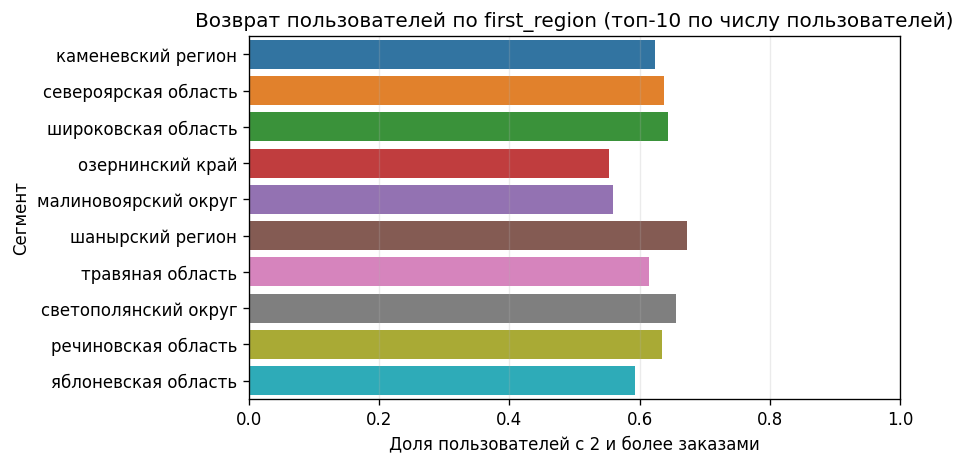

,first_region,users_cnt,share_two
0,каменевский регион,7086,0.623906
1,североярская область,3768,0.638270
2,широковская область,1223,0.644317
3,озернинский край,675,0.552593
4,малиновоярский округ,526,0.558935
5,шанырский регион,502,0.673307
6,травяная область,488,0.614754
7,светополянский округ,457,0.656455
8,речиновская область,440,0.634091
9,яблоневская область,411,0.593674


In [248]:
region_top = plot_top_segments(user_profile_clean, 'first_region', top_n=10)
region_top

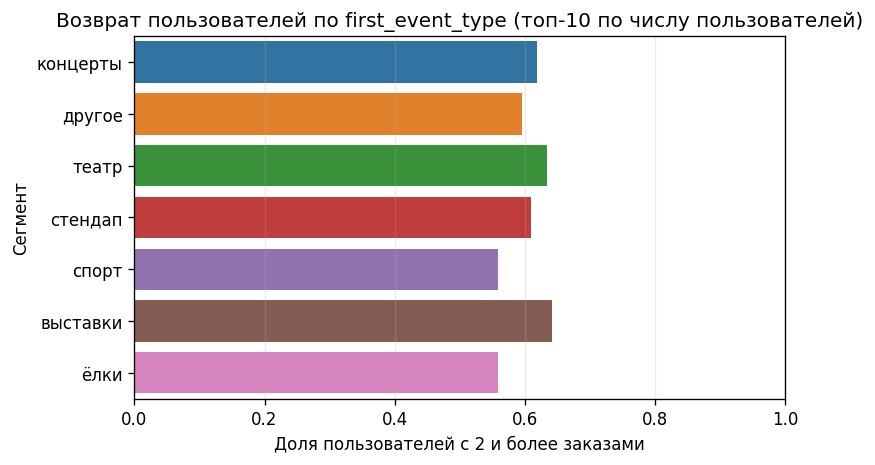

,first_event_type,users_cnt,share_two
0,концерты,9564,0.618151
1,другое,5401,0.595630
2,театр,4245,0.634393
3,стендап,1110,0.609009
4,спорт,794,0.557935
5,выставки,413,0.641646
6,ёлки,95,0.557895


In [249]:
first_event_type_top = plot_top_segments(user_profile_clean, 'first_event_type')
first_event_type_top

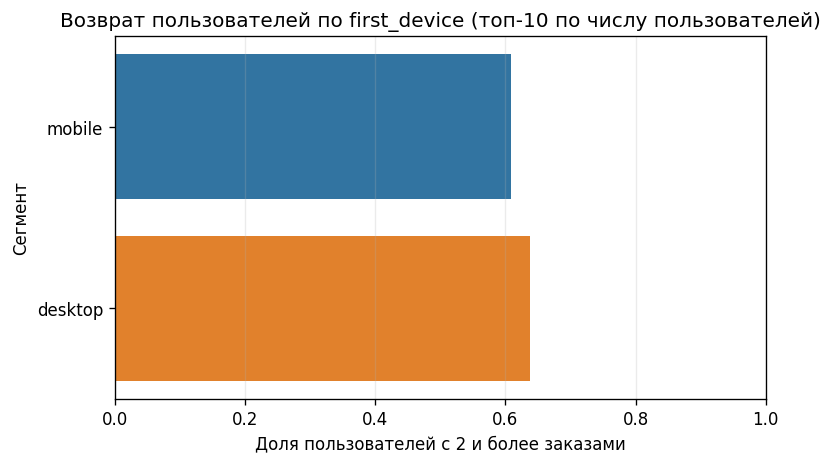

,first_device,users_cnt,share_two
0,mobile,17906,0.608008
1,desktop,3716,0.638321


In [250]:
device_top = plot_top_segments(user_profile_clean, 'first_device')
device_top

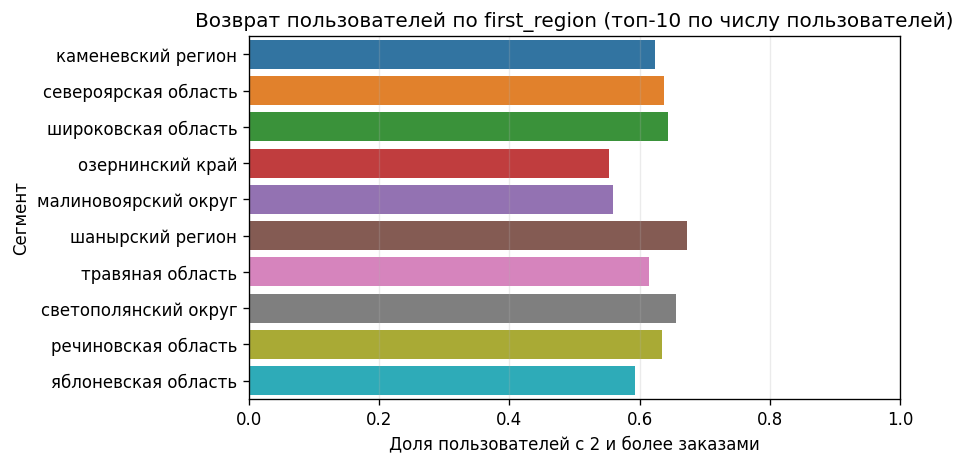

,first_region,users_cnt,share_two
0,каменевский регион,7086,0.623906
1,североярская область,3768,0.638270
2,широковская область,1223,0.644317
3,озернинский край,675,0.552593
4,малиновоярский округ,526,0.558935
5,шанырский регион,502,0.673307
6,травяная область,488,0.614754
7,светополянский округ,457,0.656455
8,речиновская область,440,0.634091
9,яблоневская область,411,0.593674


In [251]:
region_top = plot_top_segments(user_profile_clean, 'first_region', top_n=10)
region_top

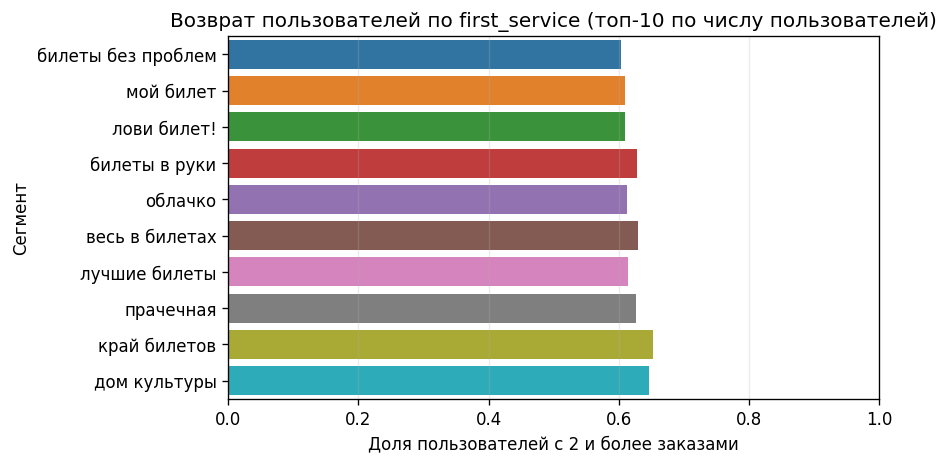

,first_service,users_cnt,share_two
0,билеты без проблем,5167,0.603251
1,мой билет,2970,0.608754
2,лови билет!,2812,0.609531
3,билеты в руки,2557,0.627689
4,облачко,2177,0.612311
5,весь в билетах,1286,0.629082
6,лучшие билеты,1182,0.613367
7,прачечная,583,0.626072
8,край билетов,454,0.651982
9,дом культуры,356,0.646067


In [252]:
service_top = plot_top_segments(user_profile_clean, 'first_service', top_n=10)
service_top

**Тип первого мероприятия**

Самые массовые точки входа: концерты, другое, театр.
Доля повторных покупок во всех крупных категориях находится в диапазоне 0.59-0.63.
Категории с более высокой долей возврата (например, выставки) имеют малый размер по количеству пользователей.

**Тип устройства первого заказа**

Основной поток пользователей приходит с мобильных устройств.
Пользователи, начавшие с десктопа, показывают немного более высокую долю возврата, но разница невелика.

**Регион первого заказа**

Наибольшее количество пользователей сконцентрировано в 3 крупных регионах.
Доля повторных заказов в крупных регионах колеблется в пределах 0.62-0.64.

**Билетный оператор первого заказа**

Различия в доле возврата между крупнейшими операторами минимальны
Более высокие значения возврата наблюдаются у некоторых операторов с меньшим числом пользователей



---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1**

Пользователи, пришедшие на спортивные мероприятия, реже возвращаются, чем те, кто начал с концертов.
Доля вернувшихся на спортивные мероприятия 0.558, а доля вернувшихся на концерты 0.618.

**Вывод: гипотеза 1 не подтверждается.**

**Гипотеза 2**

Регион с наибольшим числом пользователей (каменевский регион, 7085) имеет долю возвратов 0.624. Регионы с меньшим числом пользователей (например, шанырский регион, 500) могут иметь выше долю возвратов 0.672.
Нет прямой зависимости «чем больше пользователей - тем выше доля повторных заказов».

**Вывод: гипотеза 2 не подтверждается.**

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


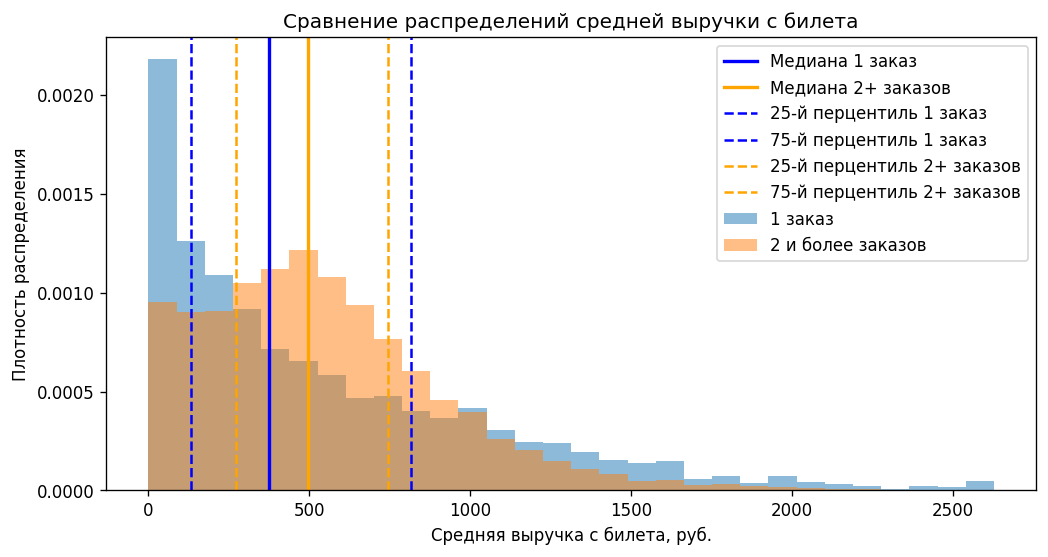

In [253]:
# Группы пользователей
one_order_users = user_profile_clean[user_profile_clean['is_two'] == 0]
repeat_users = user_profile_clean[user_profile_clean['is_two'] == 1]

# Медианы и перцентили
median_one = one_order['avg_revenue_rub'].median()
q25_one = one_order['avg_revenue_rub'].quantile(0.25)
q75_one = one_order['avg_revenue_rub'].quantile(0.75)

median_repeat = repeat_users['avg_revenue_rub'].median()
q25_repeat = repeat_users['avg_revenue_rub'].quantile(0.25)
q75_repeat = repeat_users['avg_revenue_rub'].quantile(0.75)

plt.figure(figsize=(10,5), dpi =120)

# Гистограммы
plt.hist(one_order_users['avg_revenue_rub'], bins=30, alpha=0.5, density=True, label='1 заказ')
plt.hist(repeat_users['avg_revenue_rub'], bins=30, alpha=0.5, density=True, label='2 и более заказов')

# Вертикальные линии медиан
plt.axvline(median_one, color='blue', linestyle='-', linewidth=2, label='Медиана 1 заказ')
plt.axvline(median_repeat, color='orange', linestyle='-', linewidth=2, label='Медиана 2+ заказов')

# Вертикальные линии 25 и 75 перцентилей
plt.axvline(q25_one, color='blue', linestyle='--', linewidth=1.5, label='25-й перцентиль 1 заказ')
plt.axvline(q75_one, color='blue', linestyle='--', linewidth=1.5, label='75-й перцентиль 1 заказ')
plt.axvline(q25_repeat, color='orange', linestyle='--', linewidth=1.5, label='25-й перцентиль 2+ заказов')
plt.axvline(q75_repeat, color='orange', linestyle='--', linewidth=1.5, label='75-й перцентиль 2+ заказов')

plt.xlabel('Средняя выручка с билета, руб.')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределений средней выручки с билета')
plt.legend()
plt.show()

In [254]:
print("\nПользователи с 1 заказом")
print(one_order_users['avg_revenue_rub'].quantile([0.25, 0.5, 0.75]))

print("\nПользователи с 2 и более заказами")
print(repeat_users['avg_revenue_rub'].quantile([0.25, 0.5, 0.75]))


Пользователи с 1 заказом
0.25    133.055000
0.50    378.869995
0.75    830.975006
Name: avg_revenue_rub, dtype: float64

Пользователи с 2 и более заказами
0.25    271.682495
0.50    496.543335
0.75    745.630554
Name: avg_revenue_rub, dtype: float64


Для пользователей с одним заказом центральная часть распределения (25-75%) лежит между ~130 и ~831 руб., при этом медиана составляет ~379 руб.Распределение достаточно растянутое: присутствует заметная доля как очень дешёвых, так и более дорогих покупок

Для вернувшихся пользователей центральная часть распределения (25–75%) лежит между ~272 и ~746 руб., при этом медиана составляет около 497 руб.Распределение более компактное: крайние значения встречаются реже

Основные значения средней выручки у пользователей с одним заказом сосредоточены в более низком ценовом сегменте, с выраженным разбросом и заметной долей дешёвых покупок.У вернувшихся пользователей распределение смещено вправо: типичная выручка выше, а сами значения более сгруппированы.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


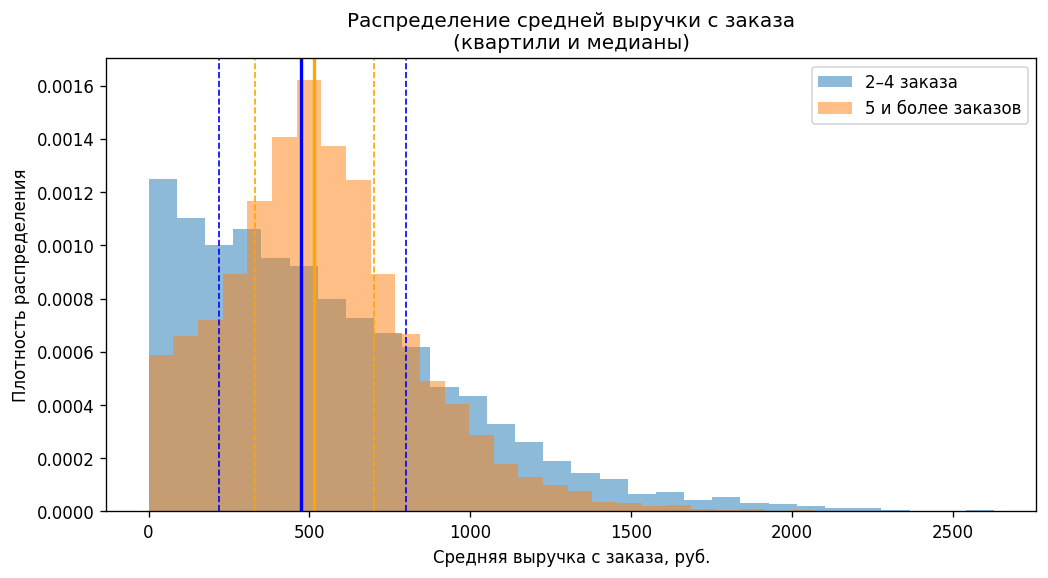

In [255]:
# группы пользователей
users_2_4 = user_profile_clean[
    (user_profile_clean['is_two'] == 1) &
    (user_profile_clean['is_five'] == 0)
]

users_5_plus = user_profile_clean[
    user_profile_clean['is_five'] == 1
]

# считаем квартили
q_2_4 = users_2_4['avg_revenue_rub'].quantile([0.25, 0.5, 0.75])
q_5 = users_5_plus['avg_revenue_rub'].quantile([0.25, 0.5, 0.75])

plt.figure(figsize=(10, 5), dpi=120)

# гистограммы
plt.hist(
    users_2_4['avg_revenue_rub'],
    bins=30,
    alpha=0.5,
    density=True,
    label='2–4 заказа'
)

plt.hist(
    users_5_plus['avg_revenue_rub'],
    bins=30,
    alpha=0.5,
    density=True,
    label='5 и более заказов'
)

# квартили и медианы: 2-4 заказа
plt.axvline(q_2_4[0.25],color='blue', linestyle='--', linewidth=1)
plt.axvline(q_2_4[0.5],color='blue', linestyle='-', linewidth=2)
plt.axvline(q_2_4[0.75],color='blue', linestyle='--', linewidth=1)



# квартили и медианы: 5+ заказов
plt.axvline(q_5[0.25],color='orange', linestyle='--', linewidth=1)
plt.axvline(q_5[0.5],color='orange', linestyle='-', linewidth=2)
plt.axvline(q_5[0.75],color='orange', linestyle='--', linewidth=1)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа\n(квартили и медианы)')
plt.legend()
plt.show()

In [256]:
print('2–4 заказа:')
print(users_2_4['avg_revenue_rub'].quantile([0.25, 0.5, 0.75]))

print('\n5 и более заказов:')
print(users_5_plus['avg_revenue_rub'].quantile([0.25, 0.5, 0.75]))

2–4 заказа:
0.25    219.597504
0.50    472.498337
0.75    799.043762
Name: avg_revenue_rub, dtype: float64

5 и более заказов:
0.25    331.687775
0.50    513.299988
0.75    701.032074
Name: avg_revenue_rub, dtype: float64


Пользователи с 5 и более заказами демонстрируют немного более высокий и стабильный средний чек.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [257]:
# создаём сегменты
bins = [1, 2, 3, 5, float('inf')]
labels = [
    '1–2 билета',
    '2–3 билета',
    '3–5 билетов',
    '5 и более билетов'
]

user_profile_clean['tickets_segment'] = pd.cut(
    user_profile_clean['avg_tickets_count'],
    bins=bins,
    labels=labels,
    right=False
)

In [258]:
tickets_stats = (
    user_profile_clean
    .groupby('tickets_segment')
    .agg(
        users_cnt=('user_id', 'count'),
        #Доля пользователей, совершивших повторные заказы
        share_two=('is_two', 'mean')
    )
    .reset_index()
)

tickets_stats

,tickets_segment,users_cnt,share_two
0,1–2 билета,2410,0.512448
1,2–3 билета,9486,0.735610
2,3–5 билетов,9065,0.542967
3,5 и более билетов,661,0.187595


- Связь между средним числом билетов и повторными покупками нелинейная.

- Наиболее вовлечённый сегмент - 2-3 билета, где наблюдается максимальная доля повторных заказов 0.74.

- Сегмент 5 и более билетов демонстрирует наименьшую долю повторных заказов 0.18.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [259]:
user_profile_clean['first_weekday'] = (
    user_profile_clean['first_order_dt']
    .dt.day_name()
)

weekday_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
]

user_profile_clean['first_weekday'] = pd.Categorical(
    user_profile_clean['first_weekday'],
    categories=weekday_order,
    ordered=True
)

weekday_stats = (
    user_profile_clean
    .groupby('first_weekday')
    .agg(
        users_cnt=('user_id', 'count'),
        share_two=('is_two', 'mean')
    )
    .reset_index()
)

weekday_stats

,first_weekday,users_cnt,share_two
0,Monday,2918,0.629883
1,Tuesday,3175,0.618898
2,Wednesday,3061,0.622672
3,Thursday,3112,0.594473
4,Friday,3256,0.597666
5,Saturday,3323,0.627746
6,Sunday,2777,0.600648


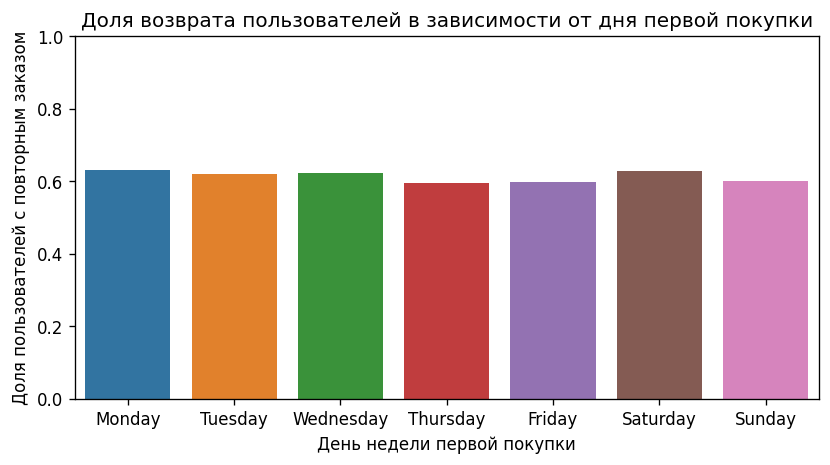

In [260]:
plt.figure(figsize=(8, 4), dpi=120)

sns.barplot(
    data=weekday_stats,
    x='first_weekday',
    y='share_two'
)

plt.xlabel('День недели первой покупки')
plt.ylabel('Доля пользователей с повторным заказом')
plt.title('Доля возврата пользователей в зависимости от дня первой покупки')
plt.ylim(0, 1)

plt.show()

- Разброс значений небольшой от ~0.59 до ~0.63. Понедельник и суббота — доля возвращающихся пользователей чуть выше среднего, а четверг и пятница — чуть ниже.
- Можно сделать вывод, что день недели, в который была совершена первая покупка, не оказывает существенного влияния на вероятность повторных заказов.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [261]:
#Группы пользователей
# Группа пользователей с 2–4 заказами
group_2_4 = user_profile_clean[
    (user_profile_clean['is_two'] == 1) &
    (user_profile_clean['is_five'] == 0)
]

# Группа пользователей с 5 и более заказами
group_5_plus = user_profile_clean[
    user_profile_clean['is_five'] == 1
]

avg_interval_2_4 = group_2_4['avg_days_between_orders'].mean()
avg_interval_5_plus = group_5_plus['avg_days_between_orders'].mean()

print(f'Средний интервал (2–4 заказа): {avg_interval_2_4:.1f} дней')
print(f'Средний интервал (5+ заказов): {avg_interval_5_plus:.1f} дней')

Средний интервал (2–4 заказа): 21.3 дней
Средний интервал (5+ заказов): 9.9 дней


In [262]:
group_2_4['avg_days_between_orders'].describe()


count    7144.000000
mean       21.346760
std        28.513086
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between_orders, dtype: float64

In [263]:
group_5_plus['avg_days_between_orders'].describe()

count    6115.000000
mean        9.904899
std         7.806657
min         0.000000
25%         3.884034
50%         8.125000
75%        14.105556
max        37.500000
Name: avg_days_between_orders, dtype: float64

- Пользователи, совершившие 5 и более заказов, характеризуются существенно меньшим средним интервалом между покупками (около 10 дней) по сравнению с пользователями, сделавшими 2-4 заказа (около 21 дня). Кроме того, у пользователей с большим числом заказов интервалы между покупками более стабильны и составляют от 4 до 14 дней, в то время как у пользователей с меньшим числом заказов наблюдаются длительные паузы, отсновное значение интервалов от 0 до 34 дней.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [264]:
!pip install phik

from phik import phik_matrix

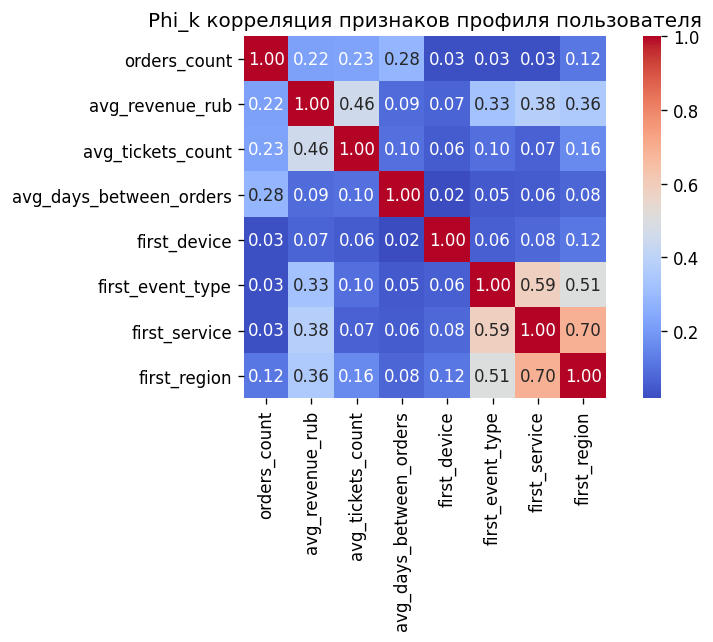

In [265]:
corr_df = user_profile_clean[
    [
        'orders_count',
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_between_orders',
        'first_device',
        'first_event_type',
        'first_service',
        'first_region'
    ]
]

interval_cols = [
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders'
]

phik_corr = corr_df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(8, 4), dpi=120)

sns.heatmap(
    phik_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)

plt.title('Phi_k корреляция признаков профиля пользователя')
plt.show()

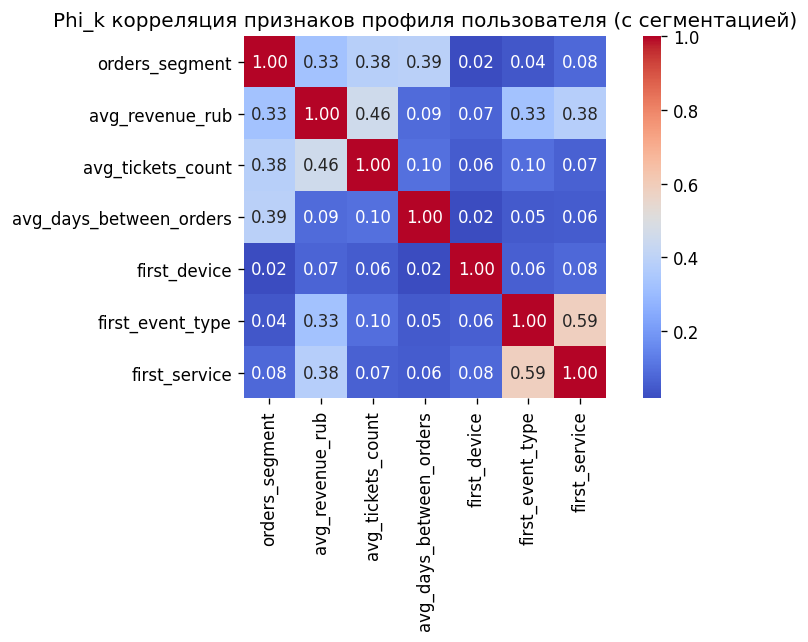

In [266]:
def orders_segment(row):
    if row['is_five'] == 1:
        return '5+ заказов'
    elif row['is_two'] == 1:
        return '2–4 заказа'
    else:
        return '1 заказ'

user_profile_clean['orders_segment'] = (
    user_profile_clean
    .apply(orders_segment, axis=1)
)

corr_df_seg = user_profile_clean[
    [
        'orders_segment',
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_between_orders',
        'first_device',
        'first_event_type',
        'first_service'
    ]
]

phik_corr_seg = corr_df_seg.phik_matrix(
    interval_cols=[
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_between_orders'
    ]
)

phik_corr = corr_df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(8, 4), dpi=120)

sns.heatmap(
    phik_corr_seg,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)

plt.title('Phi_k корреляция признаков профиля пользователя (с сегментацией)')
plt.show()

- Корреляционный анализ с использованием коэффициента phi_k показал, что количество заказов пользователя в наибольшей степени связано со средним интервалом между заказами(0,39), средним числом билетов в заказе(0,38) и средней выручкой(0,35).
- Удержание пользователей в большей степени определяется их последующим покупательским поведением, а не характеристиками первого заказа.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Предобработка.**

В рамках проекта были использованы данные о заказах пользователей сервиса Яндекс Афиша за 2024 год. Исходная выгрузка содержала более 290 тысяч заказов и включала информацию о пользователях, параметрах заказа, мероприятиях и месте их проведения.

На этапе предобработки данных были выполнены следующие шаги:

- Выручка, представленная в российских рублях и казахстанских тенге, была приведена к единой валюте — рублям — с использованием официальных курсов тенге за соответствующие даты;

- Из данных были удалены заказы с отрицательной выручкой;

- Из данных удалены неявные дубликаты;

- Проведена фильтрация выбросов по полю выручки на уровне 99-го перцентиля;

- Выполнена нормализация категориальных признаков;

- Проверены пропущенные значения — пропуски обнаружены только в поле days_since_prev, что ожидаемо для пользователей с одной покупкой.

В результате предобработки было удалено около 0.01 строк, что не повлияло на репрезентативность выборки.

- На основе очищенных данных был сформирован профиль пользователя, включающий характеристики первого заказа, агрегированные показатели поведения и бинарные признаки возврата.

**Основные результаты анализа.**
- Тип устройства первого заказа, тип первого мероприятия, билетный оператор первого заказа слабо связаны с вероятностью повторных покупок. Явно выраженных «точек входа», обеспечивающих высокий уровень удержания, обнаружено не было.
- День недели первого заказа оказывает слабое влияние на удержание: различия между днями незначительны. 
- Наиболее значимыми факторами возврата пользователей оказались интервалы между заказами. Пользователи с меньшим средним интервалом между заказами значительно чаще совершают повторные покупки;
- Более высокая средняя выручка и большее количество билетов в заказе умеренно связаны с ростом числа заказов.

**Рекомендации**

- Результаты указывают на целесообразность фокусировки маркетинговых усилий на сокращении интервалов между покупками — например, за счёт персонализированных напоминаний и предложений после первого заказа. 
- Также потенциальный эффект может дать работа с пользователями, совершающими более крупные заказы (корпоративные клиенты, организаторы групповых посещений), поскольку такие клиенты в среднем демонстрируют более высокую склонность к повторным покупкам.


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**